# Visualization of basic data

We will retrive following data from various sources for the visualization:

1) Stock price and volume history

2) Stock sentiment from various sources - we might load some preprocesed sentiment


In [1]:
import pandas as pd
import yahooquery
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.units as munits
import datetime
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec


## Import modules we created

In [2]:
from stock_modules import prep_data
from stock_modules.scrapers import news_scraper

## Input parameters - change these for specific stocks of interest


In [3]:
symbol='GME'
start_date = '2021-01-01'
end_date = '2021-01-13'

## Basic stock data plots

In [4]:
#get stock history
df = prep_data.get_stock_price(symbol,start_date,end_date)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,19.100000,17.150000,19.000000,17.250000,10022500,17.250000
2021-01-05,18.080000,17.230000,17.350000,17.370001,4961500,17.370001
2021-01-06,18.980000,17.330000,17.340000,18.360001,6056200,18.360001
2021-01-07,19.450001,18.020000,18.469999,18.080000,6129300,18.080000
2021-01-08,18.299999,17.080000,18.180000,17.690001,6482000,17.690001
2021-01-11,20.650000,19.010000,19.410000,19.940001,14927600,19.940001
2021-01-12,20.400000,19.320000,19.959999,19.950001,7060700,19.950001
2021-01-13,38.650002,20.030001,20.420000,31.400000,144501700,31.400000


### Price over time

Text(0.5, 1.0, 'GME chart')

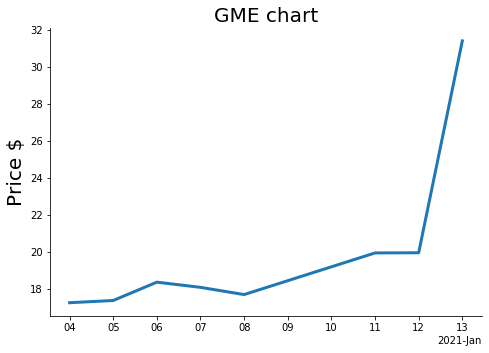

In [5]:
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(df[['Adj Close']],lw=3)
ax.set_ylabel('Price $',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
    
ax.set_title('{} chart'.format(symbol),fontsize=20)

### Price vs Volume with moving average
Plot also selects subset of data to focus as necessary

In [6]:
#get data for symbol
symbol = 'NVDA'
start_date = '2019-09-01'
end_date = '2020-09-01'
df = prep_data.get_stock_price(symbol,start_date,end_date)
# add a column for moving average
moving_avg_period = 20
df['20 day MA']=df['Adj Close'].rolling(moving_avg_period).mean()

#Limit data to second half of 2020 (optional)
#sub_start_date = '2021-01-01'
#sub_end_date = '2021-03-04'
#new_df = df.loc[sub_start_date:sub_end_date,:]

Text(0.5, 1.0, 'NVDA chart')

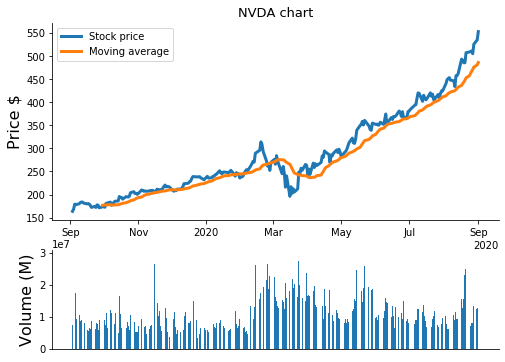

In [7]:
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

spec = gridspec.GridSpec(2,1, height_ratios=[4,2])
#fig, axs = plt.subplots(2, 1,  constrained_layout=True, figsize=(6, 6))
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[1,0])

ax1.plot(df['Adj Close'], lw=3)
ax1.plot(df['20 day MA'], lw=3)
ax1.legend(('Stock price','Moving average'))
ax1.set_ylabel('Price $',fontsize=16)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.axes.get_xaxis().set_visible(False)
ax2.bar(df['Volume'].index,df['Volume'])
ax2.set_ylabel('Volume (M)',fontsize=16)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax1.set_title('{} chart'.format(symbol),fontsize=13)

### Price vs revenues

In [8]:
#get data for symbol
symbol='NVDA'
start_date = '2019-09-01'
end_date = '2020-09-01'
df = prep_data.get_stock_price(symbol,start_date,end_date)

#Get revenue data - previously downloaded and stored in CSV
stock_file=prep_data.get_earnings_data("Data/earnings_data/{}.csv".format(symbol), df)
df = df.join(stock_file)

Text(0.5, 1.0, 'NVDA chart')

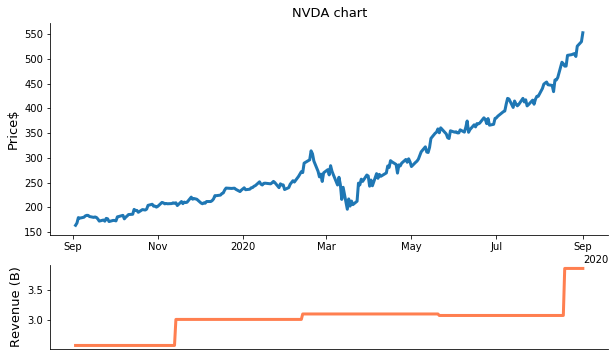

In [9]:
#converter = mdates.ConciseDateConverter()
#munits.registry[np.datetime64] = converter
#munits.registry[datetime.date] = converter
#munits.registry[datetime.datetime] = converter

spec = gridspec.GridSpec(2,1, height_ratios=[5,2])

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(spec[1,0])
ax2 = fig.add_subplot(spec[0,0])

ax1.plot(df['Reported_Revenue']/1000, lw=3,color='coral')
ax1.set_ylabel('Revenue (B)',fontsize=13)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)

ax2.plot(df['Adj Close'],lw=3)
ax2.set_ylabel('Price$',fontsize=13)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.set_title('{} chart'.format(symbol),fontsize=13)

### Sentiment data for a stock

#### Sentiment from Yahoo news

In [10]:
end_date = '2021-03-04'
news = news_scraper.get_yahoo_news(symbol,end_date)
sentiment_data=news_scraper.get_sentiment_from_news(news)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sagarjogadhenu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
news

,provider_publish_time,title,summary,compound,negative,positive,neutral
date,,,,,,,
2020-03-16,1584372091,Video game industry gets boost amid the corona...,Yahoo Finance’s Dan Howley joins Alexis Christ...,0.4019,0.000,0.109,0.891
2020-03-17,1584477500,FedEx suspends guidance amid coronavirus uncer...,Shares of FedEx surged in the extended session...,0.2244,0.000,0.040,0.960
2020-03-25,1585146050,Markets Pare Strong Gains But Follow-through D...,Rally attempt remains alive despite indexes gi...,0.6872,0.062,0.235,0.703
2020-03-25,1585146378,Apple’s gaming rules limit number of games ava...,"Yahoo Finance’s Alexis Christoforous, Brian So...",0.0772,0.000,0.042,0.958
2020-03-25,1585150171,"With Support at 200-day Line And Prior Base, C...",Nvidia had a dramatic fall but its rebound was...,0.8402,0.000,0.267,0.733
...,...,...,...,...,...,...,...
2021-02-23,1614108500,Investing In Stocks: See How To Invest In 3 Si...,"To invest in stocks, start with this simple th...",0.8176,0.000,0.288,0.712
2021-03-02,1614711421,This Stock List Has Trounced The S&P 19.8% To ...,How can you identify the best stocks to buy an...,0.6369,0.000,0.144,0.856
2021-03-05,1614976854,"How Nvidia Makes Money: Gaming, Data Center, a...",Nvidia&#39;s graphics segment produces the vas...,0.4588,0.000,0.182,0.818


In [12]:
#news = news.rename(columns={'date':'Date'})
article_count=news.groupby('date')[['title']].count().sort_index()
article_count.index = article_count.index.astype('datetime64[ns]')

Text(0.5, 1.0, 'NVDA News')

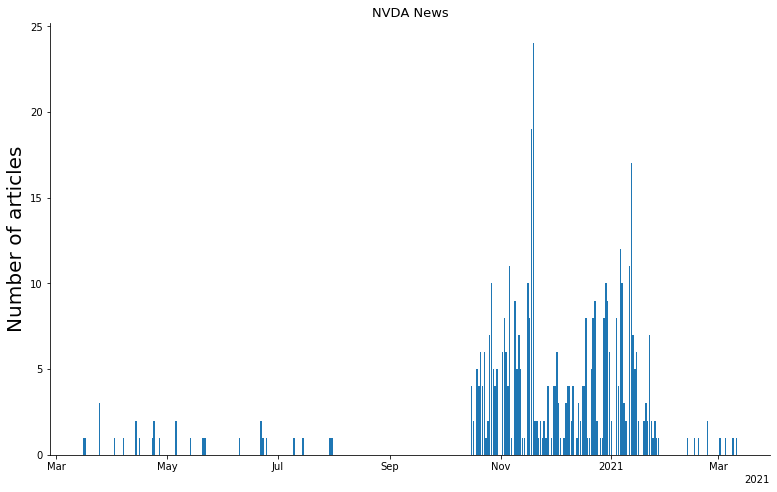

In [13]:
#converter = mdates.ConciseDateConverter()
#munits.registry[np.datetime64] = converter
#munits.registry[datetime.date] = converter
#munits.registry[datetime.datetime] = converter

fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(article_count.index,article_count['title'] )
ax.set_ylabel('Number of articles',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('{} News'.format(symbol),fontsize=13)

In [14]:
s= news.groupby('date')[['negative', 'positive', 'neutral']].sum()
s.index = s.index.astype('datetime64[ns]')

Text(0.5, 1.0, 'NVDA News sentiment')

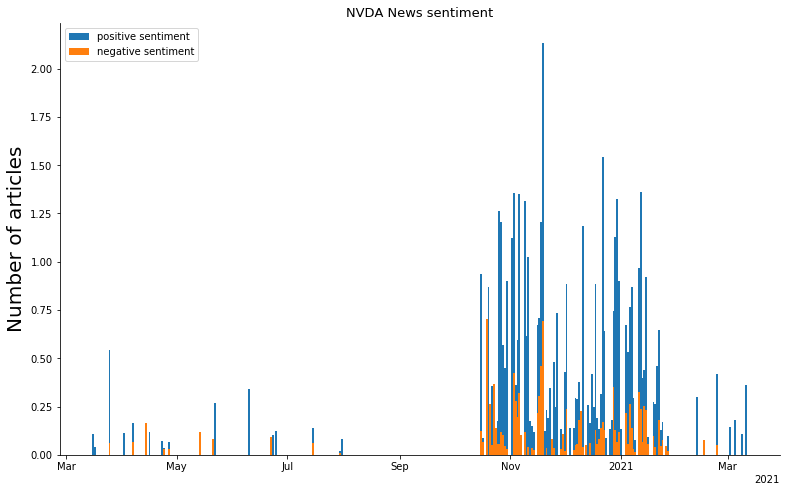

In [15]:
#converter = mdates.ConciseDateConverter()
#munits.registry[np.datetime64] = converter
#munits.registry[datetime.date] = converter
#munits.registry[datetime.datetime] = converter

fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(s.index,s['positive'],width=1,label='positive sentiment')
ax.bar(s.index,s['negative'],width=1,label='negative sentiment')
plt.legend(loc="upper left")
#ax.bar(s.index,s['neutral'])
ax.set_ylabel('Number of articles',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('{} News sentiment'.format(symbol),fontsize=13)

### Twitter sentiment data

In [16]:

symbol = 'PANW'
sentiment_data1=pd.read_csv('Data/Twitter_data/cleanTwitter_data/{}_Twitavg.csv'.format(symbol))
symbol = 'MELI'
sentiment_data=pd.read_csv('Data/Twitter_data/cleanTwitter_data/{}_Twitavg.csv'.format(symbol))


In [17]:
sentiment_data['Date'] = sentiment_data['Unnamed: 0']
sentiment_data = sentiment_data.set_index('Date')
sentiment_data1['Date'] = sentiment_data1['Unnamed: 0']
sentiment_data1 = sentiment_data1.set_index('Date')
sentiment_data.index = sentiment_data.index.astype('datetime64[ns]')
sentiment_data1.index = sentiment_data1.index.astype('datetime64[ns]')

Text(0.5, 1.0, 'MELI and PANW News sentiment overlay')

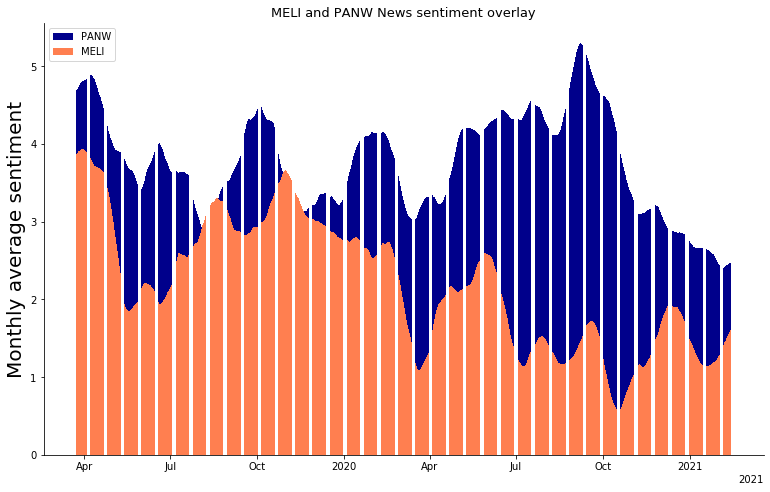

In [18]:
#converter = mdates.ConciseDateConverter()
#munits.registry[np.datetime64] = converter
#munits.registry[datetime.date] = converter
#munits.registry[datetime.datetime] = converter

fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(sentiment_data.index, sentiment_data['monthly average'],color='darkblue',label='PANW')
ax.bar(sentiment_data1.index, sentiment_data1['monthly average'],color='coral',label='MELI')
#ax.bar(s.index,s['neutral'])
plt.legend(loc="upper left")
ax.set_ylabel('Monthly average sentiment',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('MELI and PANW News sentiment overlay'.format(symbol),fontsize=13)

### Comparision between Reddit, Twitter and News sentiment

In [19]:
symbol = 'BABA'
t_sentiment=pd.read_csv('Data/Twitter_data/cleanTwitter_data/{}_Twitavg.csv'.format(symbol))
r_sentiment = pd.read_csv('Data/Reddit_data/cleanReddit_data/{}_avg.csv'.format(symbol))
end_date = '2021-03-03'
news = news_scraper.get_yahoo_news(symbol,end_date)
n_sentiment=news_scraper.get_sentiment_from_news(news)
#n_sentiment['Monthly Sentiment'] = n_sentiment['Avg Sentiment'].rolling(20, win_type='triang').mean()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sagarjogadhenu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [20]:
t_sentiment.rename({'Unnamed: 0': 'Date', 'monthly average':'t_m average'}, axis=1,inplace=True)
t_sentiment = t_sentiment.set_index('Date')
t_sentiment.index = t_sentiment.index.astype('datetime64[ns]')
r_sentiment.rename({'Unnamed: 0': 'Date', 'monthly average':'r_m average'}, axis=1,inplace=True)
r_sentiment = r_sentiment.set_index('Date')
r_sentiment.index = r_sentiment.index.astype('datetime64[ns]')
n_sentiment.rename({'weekly average':'n_w average','monthly average':'n_m average'}, axis=1,inplace=True)
sentiment_data = pd.concat([t_sentiment, r_sentiment],axis=1)
sentiment_data = sentiment_data.join(n_sentiment[['n_w average', 'n_m average']])
sentiment_data = sentiment_data.fillna(0)

In [21]:
sentiment_data

,Daily average,weekly average,t_m average,long term average,short term average,Daily average,weekly average,r_m average,long term average,short term average,n_w average,n_m average
Date,,,,,,,,,,,,
2019-02-13,0.192797,0.000000,0.000000,0.000000,0.000000,0.257233,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-02-14,0.320125,0.000000,0.000000,0.000000,0.000000,0.620445,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-02-15,0.126100,0.000000,0.000000,0.000000,0.000000,0.239967,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-02-16,0.188809,0.000000,0.000000,0.000000,0.000000,-0.145315,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-02-17,0.226480,0.000000,0.000000,0.000000,0.000000,0.046117,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-09,0.121434,0.531459,2.505595,6.094057,0.531459,0.182663,0.297505,1.225916,2.735914,0.297505,0.0,0.0
2021-02-10,0.121434,0.500977,2.516651,6.086418,0.500977,0.200142,0.568943,1.246743,2.761480,0.568943,0.0,0.0
2021-02-11,0.121434,0.485736,2.528211,6.078557,0.485736,-0.007736,0.613816,1.269177,2.783417,0.613816,0.0,0.0


Text(0.5, 1.0, 'Comparision of different sentiment sources')

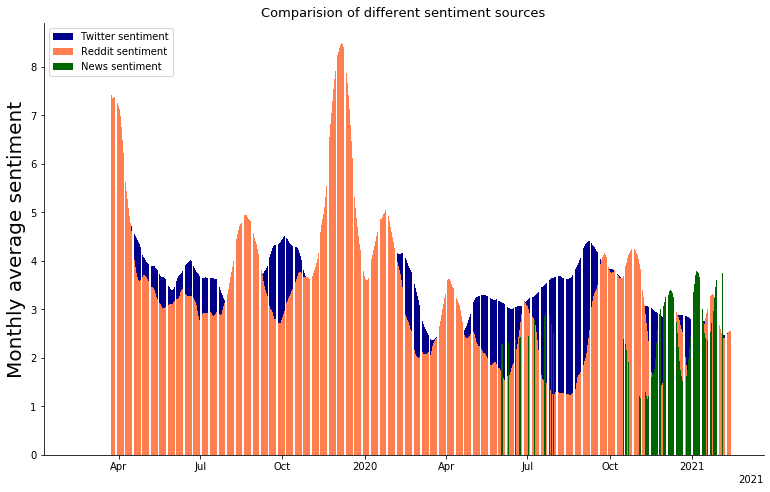

In [22]:
#converter = mdates.ConciseDateConverter()
#munits.registry[np.datetime64] = converter
#munits.registry[datetime.date] = converter
#munits.registry[datetime.datetime] = converter

fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(sentiment_data.index, sentiment_data['t_m average'],color='darkblue', label='Twitter sentiment')
ax.bar(sentiment_data.index, sentiment_data['r_m average']*2,color='coral',label='Reddit sentiment')
ax.bar(sentiment_data.index, sentiment_data['n_m average'],color='darkgreen',label='News sentiment')
plt.legend(loc="upper left")
ax.set_ylabel('Monthly average sentiment',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Comparision of different sentiment sources'.format(symbol),fontsize=13)

### Sentiment vs Price

In [23]:
#get data for symbol
start_date = '2020-03-15'
end_date = '2021-01-29'
symbol = 'BABA'
df = prep_data.get_stock_price(symbol,start_date,end_date)

#Get revenue data - previously downloaded and stored in CSV
stock_file=prep_data.get_earnings_data('Data/earnings_data/{}.csv'.format(symbol), df)
df = df.join(stock_file)
news = news_scraper.get_yahoo_news(symbol,end_date)
n_sentiment=news_scraper.get_sentiment_from_news(news)
df = df.join(n_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sagarjogadhenu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [24]:
# fill NAs in the dataframe
df['weekly average'] = df['weekly average'].interpolate()
df['monthly average'] = df['monthly average'].interpolate()

Text(0.5, 1.0, 'BABA chart')

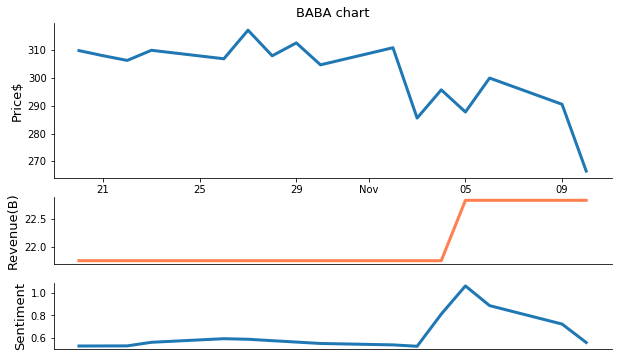

In [25]:
spec = gridspec.GridSpec(3,1, height_ratios=[7,3,3])

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[1,0])
ax3 = fig.add_subplot(spec[2,0])

ax1.plot(df.loc['2020-10-20':'2020-11-10','Adj Close'],lw=3)
ax1.set_ylabel('Price$',fontsize=13)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.plot(df.loc['2020-10-20':'2020-11-10','Reported_Revenue']/1000, lw=3,color='coral')
ax2.set_ylabel('Revenue(B)',fontsize=13)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

ax3.plot(df.loc['2020-10-20':'2020-11-10','weekly average'], lw=3)
ax3.set_ylabel('Sentiment',fontsize=13)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.axes.get_xaxis().set_visible(False)

ax1.set_title('{} chart'.format(symbol),fontsize=13)

# Logistic regression

In [26]:
from sklearn import dummy, metrics, model_selection, preprocessing
from sklearn.linear_model import LogisticRegression

In [27]:
def get_financials_and_news(symbol, start_date, end_date):
    '''
    :symbol: stock symbol. string
    :start_date: start date for analysis. string
    :end_date: end date for analysis. string
    returns a dataframe combining financials and sentiment from news 
    '''
    
    df = prep_data.get_stock_price(symbol,start_date,end_date)
    #Get revenue data - previously downloaded and stored in CSV
    stock_file=prep_data.get_earnings_data('Data/earnings_data/{}.csv'.format(symbol), df)
    df = df.join(stock_file)
    news = news_scraper.get_yahoo_news(symbol,end_date)
    n_sentiment=news_scraper.get_sentiment_from_news(news)
    df = pd.concat([df, n_sentiment[['Daily average','weekly average','monthly average','long term average']]],axis=1)
    df['Daily average'].fillna(0,inplace=True)
    df['weekly average'].fillna(0,inplace=True)
    df['monthly average'].fillna(0,inplace=True)
    df['long term average'].fillna(0,inplace=True)
    return df

### Quick run of logistic regression on one stock

In [28]:
symbol = 'GOOGL'
start_date='2020-03-05'
end_date = '2021-03-05'
df = get_financials_and_news(symbol,start_date,end_date)
df.dropna(inplace=True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sagarjogadhenu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [29]:
# add labels - stm for Short term (7 days), mtm for Medium term (month) and ltm for Long term (90 days)
df['stm'] = prep_data.prepare_output_labels(df,length=7, threshold=1)
df['mtm'] = prep_data.prepare_output_labels(df,length=20, threshold=3)
df['ltm'] = prep_data.prepare_output_labels(df,length=90, threshold=7)

In [30]:
# Pick columns of interest and split data for training and testing
# Create 
x_cols = ['Volume','Surprise_EPS', 'Estimated_Revenue', 'Reported_Revenue', 'weekly average','monthly average','long term average']

# due to rolling average, long term columns may have more NaNs so avoid dropping all of them
# by separating into different DFs
stm_df = df.loc[:,x_cols]
stm_df['stm'] = df['stm']
stm_df = stm_df.dropna()

mtm_df = df.loc[:,x_cols]
mtm_df['mtm'] = df['mtm']
mtm_df = mtm_df.dropna()

ltm_df = df.loc[:,x_cols]
ltm_df['ltm'] = df['ltm']
ltm_df = ltm_df.dropna()

In [31]:
def get_train_test_data(df,x_cols, y_cols):
    '''
    :df: dataframe
    '''
    X_train, X_test, y_train, y_test = model_selection.train_test_split(df[x_cols],df[y_cols]\
                                                                                  , test_size=0.3,random_state=44)
    cols = X_train.columns
    std = preprocessing.StandardScaler()
    X_train.loc[:, cols] = std.fit_transform(X_train)
    X_test.loc[:,cols] = std.transform(X_test)
    return X_train, X_test, y_train, y_test

In [32]:
# Quick check of logistic regression with short term data
X_train, X_test, y_train, y_test = get_train_test_data(stm_df, x_cols,['stm'])

lr= LogisticRegression(multi_class='multinomial',solver='sag')
lr.fit(X_train,np.ravel(y_train))
print('score:{}'.format(lr.score(X_test,np.ravel(y_test))))

print('confusion matrix\n',metrics.confusion_matrix(y_test,lr.predict(X_test)))


score:0.6351351351351351
confusion matrix
 [[ 2  0 12]
 [ 0  0 11]
 [ 4  0 45]]


### Logistic regression on all stocks using stored data

In [33]:
symlist = ['ADI', 'AMT', 'AMZN', 'BABA', 'COUP', 'CRM', 'ERIC', 'GOOGL', 'MELI', 'MSFT', 'NVDA', 'OKTA', 'PANW', 'PYPL', 'QCOM', 'SHOP', 'SQ', 'TMUS']
df = pd.read_csv('Data/Yahoo_data/AAPL.csv')
for symbol in symlist:
    df1 = pd.read_csv('Data/Yahoo_data/{}.csv'.format(symbol))
    df1.dropna(inplace=True)
    df = pd.concat([df,df1])

In [34]:
df['stm'] = prep_data.prepare_output_labels(df,length=7, threshold=1)
df['mtm'] = prep_data.prepare_output_labels(df,length=20, threshold=3)
df['ltm'] = prep_data.prepare_output_labels(df,length=90, threshold=7)

In [35]:
df

,Unnamed: 0,High,Low,Open,Close,Volume,Adj Close,Surprise_EPS,Total Sentiment,Avg Sentiment,Weekly Sentiment,Monthly Sentiment,Quarterly Sentiment,weekly stock,monthly stock,quarterly stock,stm,mtm,ltm
0,2020-06-01,80.587502,79.302498,79.437500,80.462502,80791200.0,80.059723,0.12,-1.2498,-0.312450,0.973379,4.341977,0.973379,3.607260,19.027492,58.905432,up,up,up
1,2020-06-02,80.860001,79.732498,80.187500,80.834999,87642800.0,80.430351,0.12,-1.6542,-0.827100,0.973379,4.341977,0.973379,6.386467,18.296536,59.921656,up,up,up
2,2020-06-03,81.550003,80.574997,81.165001,81.279999,104491200.0,80.873131,0.12,-1.6542,-0.827100,0.973379,4.341977,0.973379,8.526082,17.467392,65.381304,up,up,up
3,2020-06-04,81.404999,80.195000,81.097504,80.580002,87560400.0,80.176636,0.12,-1.7959,-0.256557,0.973379,4.341977,0.973379,4.213205,20.448625,63.361764,up,up,up
4,2020-06-05,82.937500,80.807503,80.837502,82.875000,137250400.0,82.460152,0.12,-1.7959,-0.256557,0.973379,4.341977,0.973379,2.202102,17.918543,46.121187,up,up,up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2021-01-25,132.399994,129.669998,130.750000,131.100006,2892600.0,131.100006,0.66,0.7964,0.796400,1.527000,5.579014,18.177084,-3.283215,-3.598735,14.781661,NaN,NaN,NaN
239,2021-01-26,132.710007,130.000000,130.020004,131.410004,3219000.0,131.410004,0.66,1.0743,0.358100,1.866725,5.425864,17.977461,-3.283215,-3.598735,14.781661,NaN,NaN,NaN
240,2021-01-27,130.000000,122.449997,129.690002,123.269997,7023100.0,123.269997,0.66,0.7270,0.363500,2.065925,5.288260,17.761965,-3.283215,-3.598735,14.781661,NaN,NaN,NaN
241,2021-01-28,129.600006,124.500000,125.790001,127.769997,5000200.0,127.769997,0.66,0.7270,0.363500,2.115200,5.181959,17.534219,-3.283215,-3.598735,14.781661,NaN,NaN,NaN


In [36]:
# Pick columns of interest and split data for training and testing
# Create 
#x_cols = ['Volume','Surprise_EPS', 'Estimated_Revenue', 'Reported_Revenue', 'weekly average','monthly average','long term average']
x_cols = ['Volume','Surprise_EPS', 'Weekly Sentiment','Monthly Sentiment','Quarterly Sentiment']
# due to rolling average, long term columns may have more NaNs so avoid dropping all of them
# by separating into different DFs
stm_df = df.loc[:,x_cols]
stm_df['stm'] = df['stm']
stm_df = stm_df.dropna()

mtm_df = df.loc[:,x_cols]
mtm_df['mtm'] = df['mtm']
mtm_df = mtm_df.dropna()

ltm_df = df.loc[:,x_cols]
ltm_df['ltm'] = df['ltm']
ltm_df = ltm_df.dropna()

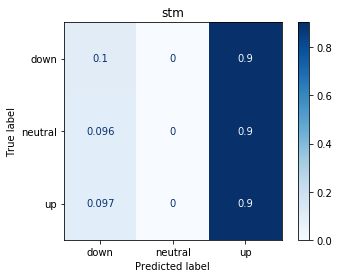

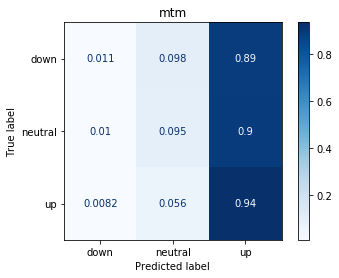

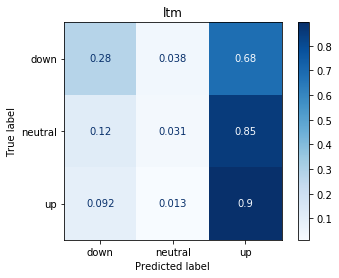

In [37]:
term_dict = {'stm':stm_df,'mtm':mtm_df,'ltm':ltm_df}
lr= LogisticRegression(multi_class='multinomial',solver='newton-cg')
for term in term_dict.keys():
    X_train, X_test, y_train, y_test = get_train_test_data(term_dict[term], x_cols,[term])
    lr.fit(X_train,np.ravel(y_train))
    disp = metrics.plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=['down','neutral','up'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    disp.ax_.set_title(term)
    plt.show()